In [ ]:
'''
The code serves three primary functions:

    Calculate A-P Profile and Identify Stripes:
        Computes the anterior-posterior (A-P) intensity profile of a fruit fly embryo by averaging pixel intensities column-wise within a specified embryo binary mask.

    Compare Whole Embryo Profiles by Alignment:
        Aligns the entire A-P profiles of the target and control embryos onto a common X-axis.
        Ensures differences in overall stripe intensity patterns can be compared across embryos by normalization. 

    Compare Stripes by Regional Alignment:
        Detects stripe boundaries using peak detection and dynamically determines start and end indices to isolate the relevant regions of interest.
        Focuses on specific stripe regions by aligning peak positions from the target and control embryos.
'''

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure, segmentation, exposure
from skimage import morphology
from skimage.color import rgb2gray
from scipy import signal, stats
import pandas as pd

In [4]:
def load_and_preprocess(image_path):
    """
    Load and preprocess the embryo image.
    
    Parameters:
        image_path (str): Path to the TIFF image
    
    Returns:
        numpy.ndarray: Preprocessed image
    """
    # Load image
    img = io.imread(image_path)
    
    # Convert to grayscale if necessary
    if len(img.shape) > 2:
        img = rgb2gray(img)

     # Normalize image by dividing by its maximum value
    img_normalized = img / np.max(img)
    
    # Enhance contrast using histogram stretching
    img_enhanced = exposure.rescale_intensity(img_normalized, in_range=(0, 1), out_range=(0, 1))
    
    # Apply Gaussian smoothing to reduce noise
    img_smooth = filters.gaussian(img_enhanced, sigma=2)
    plt.imshow(img_smooth)
    
    return img_smooth

In [6]:
def detect_embryo_boundary(image):
    """
    Detect the embryo boundary and create a mask & visualization
    
    Parameters:
        image (numpy.ndarray): Preprocessed image
    
    Returns:
        numpy.ndarray: Binary mask of the embryo
    """
    # Otsu thresholding
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    binary = morphology.remove_small_objects(binary, min_size=100)
    binary = morphology.remove_small_holes(binary, area_threshold=100)
    
    # Find the largest connected component (embryo)
    labels = measure.label(binary)
    largest_label = np.argmax(np.bincount(labels.flat)[1:]) + 1
    embryo_mask = labels == largest_label
     # Visualize steps
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # Original image
    axes[0,0].imshow(image, cmap='gray')
    axes[0,0].set_title('Original Image')
    
    # Binary after thresholding
    axes[0,1].imshow(binary, cmap='gray')
    axes[0,1].set_title('After Thresholding')
    
    # Labeled components
    axes[1,0].imshow(labels, cmap='nipy_spectral')
    axes[1,0].set_title('Connected Components')
    
    # Final mask
    axes[1,1].imshow(embryo_mask, cmap='gray')
    axes[1,1].set_title('Final Embryo Mask')
    
    plt.tight_layout()
    
    return embryo_mask

In [10]:
import numpy as np
from skimage import filters, morphology, measure
import matplotlib.pyplot as plt

def detect_embryo_boundary_alternative(image, low_percentile=10):
    """
    Detect the embryo boundary by excluding the darkest pixels and creating a mask. It's applied 
    when the stripes instead of embryo is segmented when using otsu methods
    
    Parameters:
        image (numpy.ndarray): Preprocessed image
        low_percentile (int): The lower percentile threshold for excluding pixels (default: 5)

    Returns:
        numpy.ndarray: Binary mask of the embryo
    """
    # Exclude the lowest intensity values
    lower_threshold = np.percentile(image, low_percentile)
    filtered_image = image > lower_threshold  # Exclude low values

    # Fill small holes and remove small objects
    binary = morphology.remove_small_objects(filtered_image, min_size=100)
    binary = morphology.remove_small_holes(binary, area_threshold=100)

    # Find the largest connected component (embryo)
    labels = measure.label(binary)
    largest_label = np.argmax(np.bincount(labels.flat)[1:]) + 1
    embryo_mask = labels == largest_label

    # Visualize steps
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Original image
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original Image')

    # After thresholding
    axes[0, 1].imshow(filtered_image, cmap='gray')
    axes[0, 1].set_title('After Excluding Dark Pixels')

    # Labeled components
    axes[1, 0].imshow(labels, cmap='nipy_spectral')
    axes[1, 0].set_title('Connected Components')

    # Final mask
    axes[1, 1].imshow(embryo_mask, cmap='gray')
    axes[1, 1].set_title('Final Embryo Mask')

    plt.tight_layout()

    return embryo_mask

In [12]:
from scipy.ndimage import gaussian_filter1d

def generate_ap_profile(img, mask):
    """
    Generate anterior-posterior intensity profile for the specified region,
    normalize the X-axis to percentage of embryo length, and rotate the embryo 
    so that the major axis aligns with the X-axis.
    
    Parameters:
        img (numpy.ndarray): Input image (grayscale)
        mask (numpy.ndarray): Binary mask specifying the region of interest
    
    Returns:
        tuple: (normalized_ap_positions, ap_profile)
            - normalized_ap_positions: Normalized A-P positions (0% to 100%)
            - ap_profile: A-P intensity profile
    """
    
    # Get image dimensions after rotation
    rows, cols = img.shape
    
    # Initialize A-P intensity profile
    ap_profile = np.zeros(cols)
    
    # Calculate intensity profile column by column
    for col in range(cols):
        # Pixels in the current column within the mask
        column_pixels = img[:, col] * mask[:, col]
        
        # Select valid pixels (those within the mask)
        valid_pixels = column_pixels[mask[:, col] == 1]
        
        if valid_pixels.size > 0:  # If there are valid pixels
            ap_profile[col] = np.mean(valid_pixels)
    
    # Normalize x-axis to percentage of embryo length (0 to 100%)
    normalized_ap_positions = np.linspace(0, 100, cols)
    
    # Smooth the A-P profile using Gaussian filter
    smoothed_ap_profile = gaussian_filter1d(ap_profile, sigma=10)
    
    return normalized_ap_positions, smoothed_ap_profile

In [16]:
def detect_stripes(ap_positions, intensity_profile):
    """
    Detect and segment eve stripes by peak calling algorithm
    
    Parameters:
        ap_positions (numpy.ndarray): A-P axis positions
        intensity_profile (numpy.ndarray): Intensity profile
    
    Returns:
        dict: Dictionary containing stripe boundaries and properties
    """
    # Find peaks (stripe centers)
    peaks, properties = signal.find_peaks(intensity_profile, 
                                        distance=len(ap_positions)/100,
                                        prominence=0.006)
    print("peaks = ", peaks)
    
    # Find valleys (stripe boundaries)
    valleys, _ = signal.find_peaks(-intensity_profile, 
                                 distance=len(ap_positions)/100,
                                 prominence=0.006)
    
    stripes = {}
    # Identify individual stripes
    for i in range(len(peaks)):
        stripes[f'stripe_{i+1}'] = {'center': ap_positions[peaks[i]]}
    
    return stripes

In [18]:
def plot_results(image, ap_positions, intensity_profile, stripes):
    """
    Create visualization of the analysis results.
    
    Parameters:
        image (numpy.ndarray): Original image
        ap_positions (numpy.ndarray): A-P axis positions
        intensity_profile (numpy.ndarray): Intensity profile
        stripes (dict): Stripe properties
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))
    
    # Plot original image
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Processed Image')
    
    # Plot A-P profile with stripe boundaries
    ax2.plot(ap_positions, intensity_profile, 'black', label='Intensity Profile')
    print(ap_positions, intensity_profile)
    # Highlight the stripes
    for stripe_key, stripe in stripes.items():
    # Plot vertical lines at the center of each stripe
        ax2.axvline(x=stripe['center'], color='indianred', linestyle='--')  

    ax2.set_xlabel('A-P Position (% egg length)', fontsize=12, family='Times New Roman')
    ax2.set_ylabel('Intensity', fontsize=12,family='Times New Roman')
    ax2.set_title('A-P Intensity Profile', fontsize=16, family='Arial')
    ax2.legend()
    
    plt.tight_layout()
    return fig

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_intensity(intensity_profile):
    """
    Normalize the intensity profile to range [0, 1] using min-max normalization.
    
    Parameters:
        intensity_profile (numpy.ndarray): Intensity profile to normalize.
    
    Returns:
        numpy.ndarray: Normalized intensity profile.
    """
    min_intensity = np.min(intensity_profile)
    max_intensity = np.max(intensity_profile)
    return (intensity_profile - min_intensity) / (max_intensity - min_intensity)

In [40]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

def detect_stripe_boundaries_afterCrop(ap_profile: np.ndarray, sigma: float = 5, prominence: float = 0.005):
    """
    Detect stripe boundaries based on smoothed intensity profile and peak detection.
    
    Parameters:
        ap_profile (np.ndarray): The original A-P intensity profile.
        sigma (float): Standard deviation for Gaussian smoothing.
        prominence (float): Minimum prominence of peaks to detect stripes.
    
    Returns:
        tuple: (adjusted_ap_profile, start_idx, end_idx)
            - adjusted_ap_profile: Cropped A-P profile within stripe boundaries.
            - start_idx: Index of the left boundary of the first stripe.
            - end_idx: Index of the right boundary of the last stripe.
    """
    # Smooth the profile using a Gaussian filter
    smoothed_profile = gaussian_filter1d(ap_profile, sigma=sigma)
    
    # Detect peaks in the smoothed profile
    peaks, _ = find_peaks(smoothed_profile, prominence=prominence)
    
    if len(peaks) < 2:
        # Adjust to handle cases with fewer peaks
        print("Warning: Less than two peaks detected. Returning full profile.")
        return ap_profile, 0, len(ap_profile) - 1

    # Define the start as the midpoint before the first peak
    start_idx = max(0, peaks[0] - (peaks[1] - peaks[0]) // 2)
    # Define the end as the midpoint after the last peak
    end_idx = min(len(ap_profile) - 1, peaks[-1] + (peaks[-1] - peaks[-2]) // 2)
    
    adjusted_ap_profile = ap_profile[start_idx:end_idx + 1]
    
    print('length of ap_profile is:', len(smoothed_profile))
    print('length of adjusted_ap_profile is:', len( adjusted_ap_profile))
    print('start_idx:', start_idx)
    print('end_idx:', end_idx)
    print('peaks[0] - (peaks[1] - peaks[0]) // 2:', peaks[0] - (peaks[1] - peaks[0]) // 2)
    print('len(ap_profile) - 1:', len(ap_profile) - 1)
    print('peaks[-1] + (peaks[-1] - peaks[-2]) // 2:', peaks[-1] + (peaks[-1] - peaks[-2]) // 2)

    
    return adjusted_ap_profile, start_idx, end_idx


In [42]:
import matplotlib.pyplot as plt

def align_and_plot_profiles(target_profile: np.ndarray, control_profile: np.ndarray, 
                            target_indices: tuple, control_indices: tuple):
    """
    Align and plot A-P profiles of target and control embryos on the same X-axis.
    
    Parameters:
        target_profile (np.ndarray): Cropped A-P profile of the target embryo.
        control_profile (np.ndarray): Cropped A-P profile of the control embryo.
        target_indices (tuple): (start_idx, end_idx) of the target embryo profile.
        control_indices (tuple): (start_idx, end_idx) of the control embryo profile.
    
    Returns:
        None
    """
    # Normalize X-axes to percentage of cropped region
    target_length = len(target_profile)
    control_length = len(control_profile)
    
    target_x = np.linspace(0, 100, target_length)
    control_x = np.linspace(0, 100, control_length)
    
    # Plot the profiles
    plt.figure(figsize=(10, 6))
    plt.plot(target_x, target_profile, label="Target Embryo", color='red', lw=1.5)
    plt.plot(control_x, control_profile, label="Control Embryo", color="blue", lw=1.5, linestyle="--")
    plt.xlabel("Pixel position",fontsize=12, family='Times New Roman')
    plt.ylabel("Intensity",fontsize=12, family='Times New Roman')
    plt.title("Aligned A-P Profiles of Target and Control Embryos_cropped",fontsize=16, family='Arial')
    plt.legend()
    plt.show()


peaks =  [ 138  538 1087 1422]
{'stripe_1': {'center': 8.937823834196891}, 'stripe_2': {'center': 34.84455958549223}, 'stripe_3': {'center': 70.40155440414507}, 'stripe_4': {'center': 92.09844559585491}}
[0.00000000e+00 6.47668394e-02 1.29533679e-01 ... 9.98704663e+01
 9.99352332e+01 1.00000000e+02] [0.30420411 0.30420925 0.30421942 ... 0.29071269 0.29046153 0.29033522]


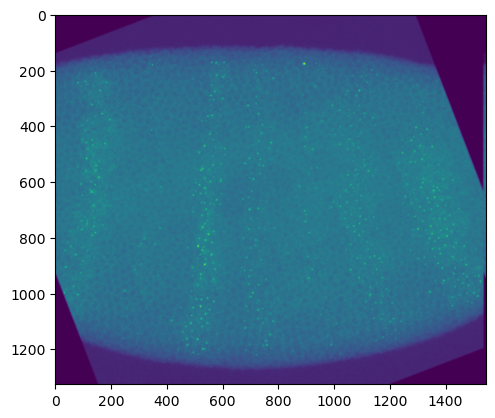

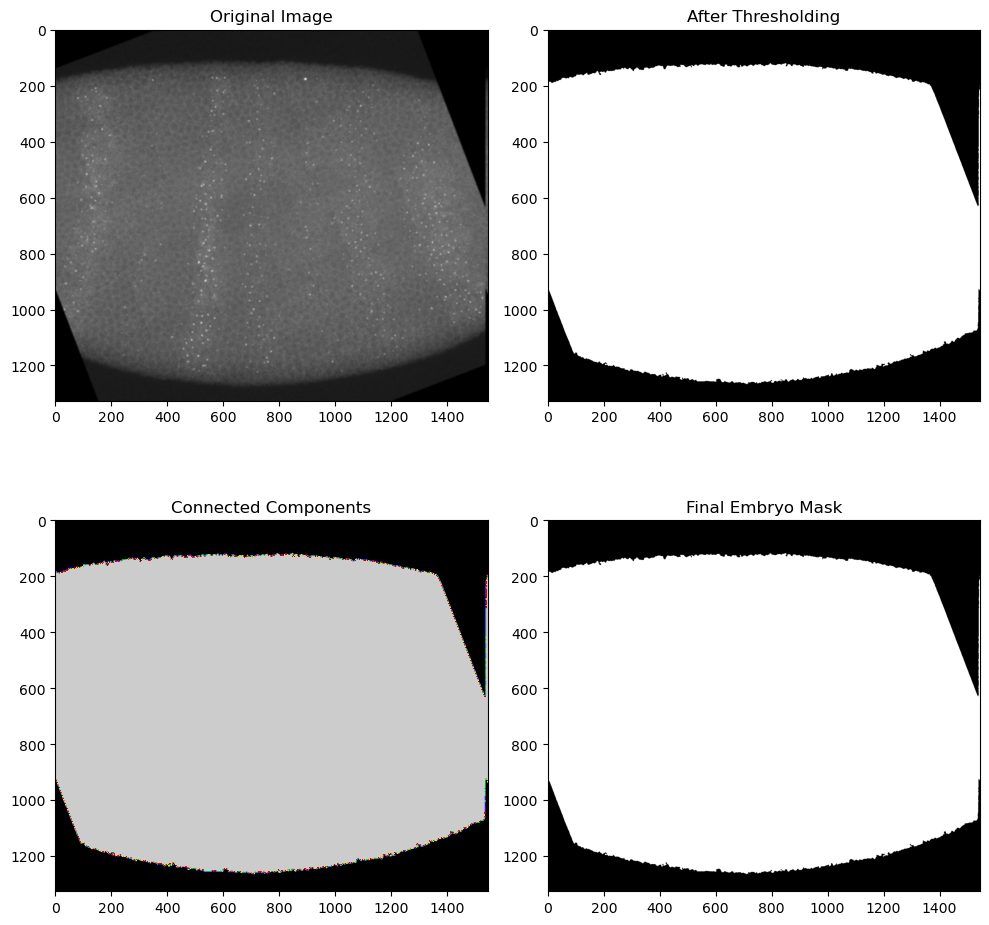

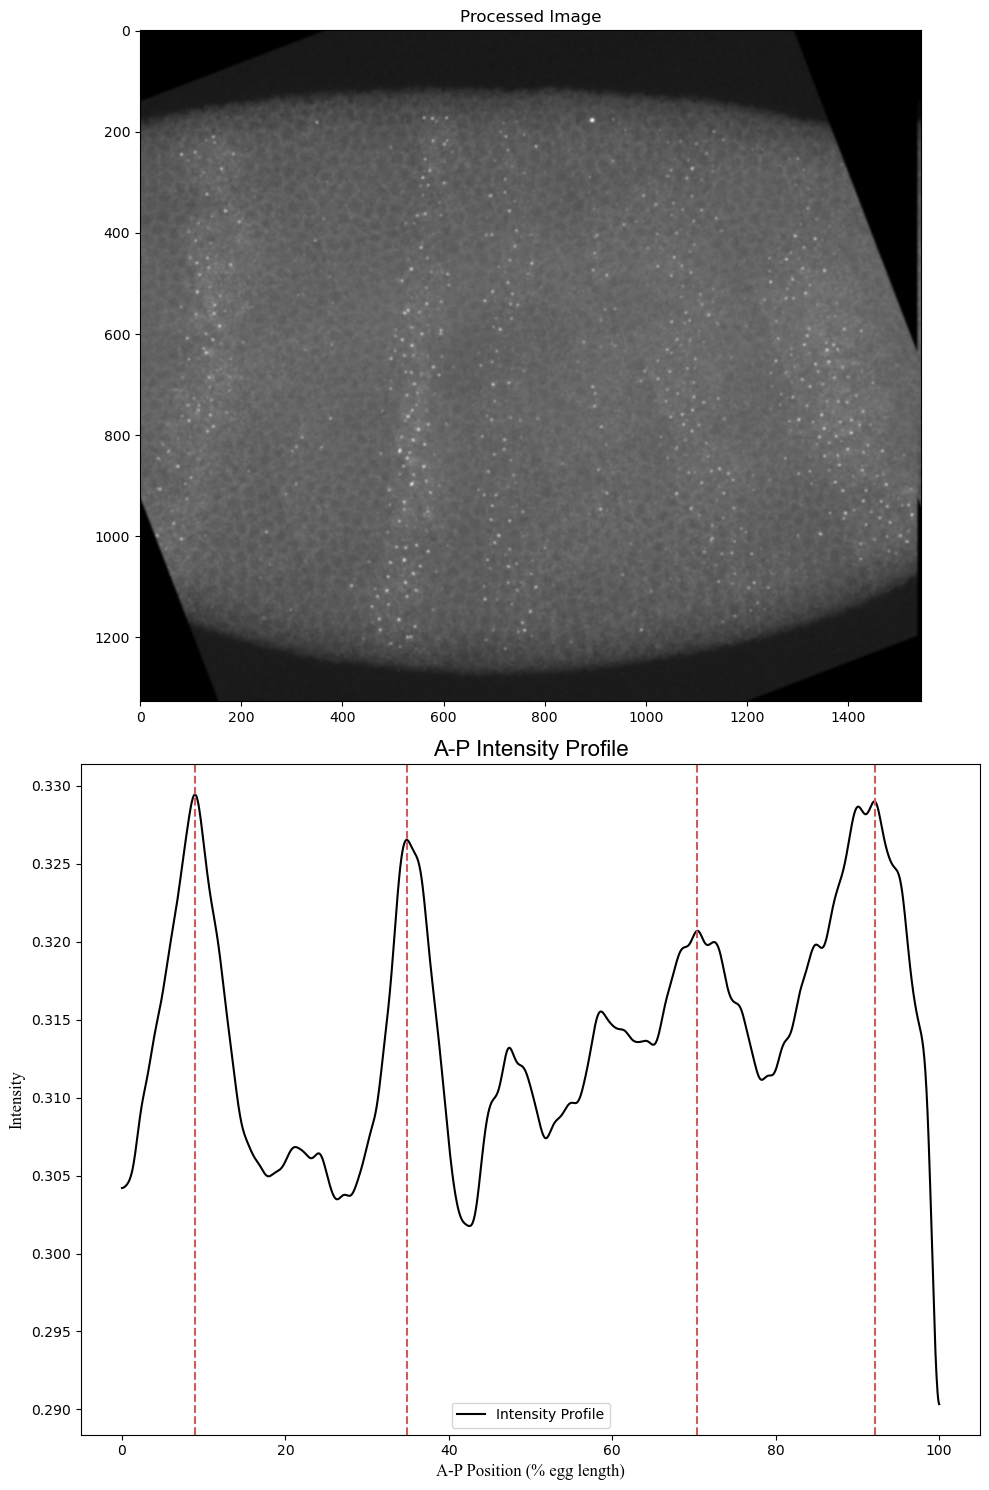

In [44]:
    """
    Try D4 embryo profile
    """
    image_path = "./processed images/D4 z=2 8b green.tif"
    # Load and preprocess image
    img = load_and_preprocess(image_path)
    
    # Detect embryo boundary
    embryo_mask = detect_embryo_boundary(img)
    
    # Generate A-P profile
    ap_positions, intensity_profile = generate_ap_profile(img, embryo_mask)
    
    # Detect stripes
    stripes = detect_stripes(ap_positions, intensity_profile)
    print(stripes)
    
    # Analyze eve2 stripe
    #eve2_analysis = analyze_eve2_stripe(stripes)
    
    # Create visualization
    fig = plot_results(img, ap_positions, intensity_profile, stripes)
    

peaks =  [ 148  559  713  915 1104 1451]
{'stripe_1': {'center': 9.660574412532638}, 'stripe_2': {'center': 36.48825065274152}, 'stripe_3': {'center': 46.540469973890346}, 'stripe_4': {'center': 59.725848563968675}, 'stripe_5': {'center': 72.0626631853786}, 'stripe_6': {'center': 94.71279373368147}}
[0.00000000e+00 6.52741514e-02 1.30548303e-01 ... 9.98694517e+01
 9.99347258e+01 1.00000000e+02] [0.30605271 0.30605325 0.30605454 ... 0.30872503 0.30863629 0.30859168]


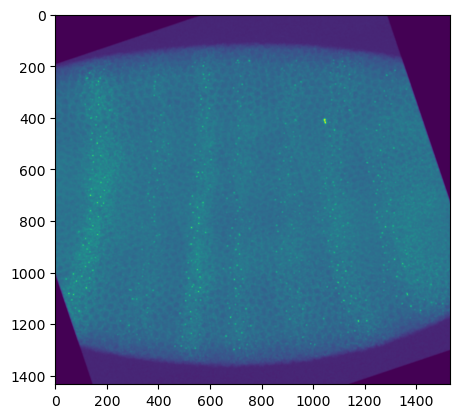

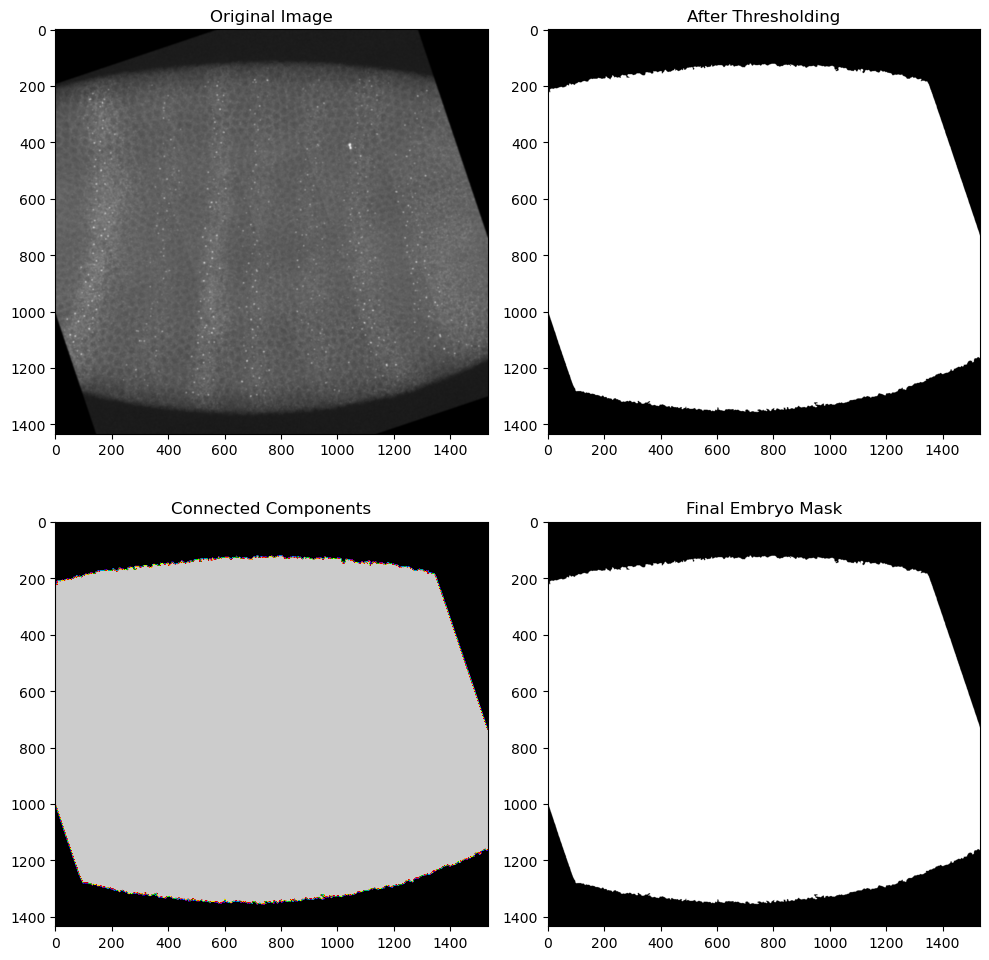

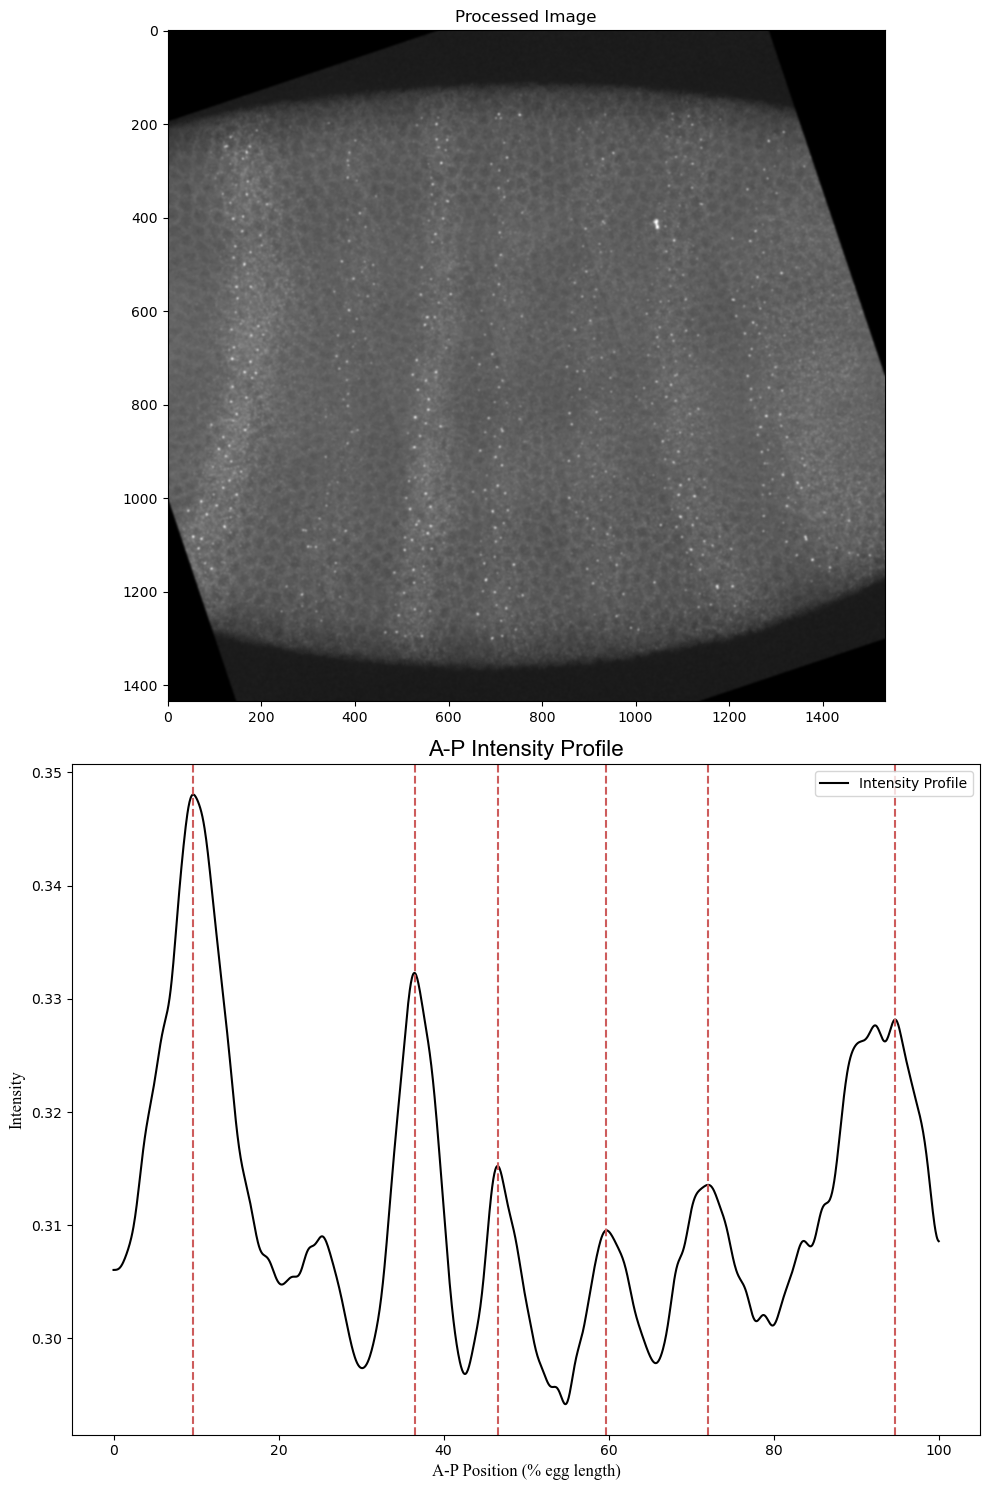

In [46]:
    #Try C4 embryo profile, and compare it with control at similar stage

    image_path_exp = "./processed images/C4 z=2 8b green.tif"
    # Load and preprocess image
    img_exp = load_and_preprocess(image_path_exp)
    
    # Detect embryo boundary
    embryo_mask_exp = detect_embryo_boundary(img_exp)
    
    # Generate A-P profile
    ap_positions_exp, intensity_profile_exp = generate_ap_profile(img_exp, embryo_mask_exp)
    
    # Detect stripes
    stripes_exp = detect_stripes(ap_positions_exp, intensity_profile_exp)
    print(stripes_exp)
    
    # Analyze eve2 stripe
    #eve2_analysis = analyze_eve2_stripe(stripes)
    
    # Create visualization
    fig_exp = plot_results(img_exp, ap_positions_exp, intensity_profile_exp, stripes_exp)


peaks =  [ 316  799 1167 1518 1897 2212 2739]
{'stripe_1': {'center': 10.131452388586085}, 'stripe_2': {'center': 25.617184995190765}, 'stripe_3': {'center': 37.41583840974671}, 'stripe_4': {'center': 48.66944533504328}, 'stripe_5': {'center': 60.82077588970824}, 'stripe_6': {'center': 70.9201667201026}, 'stripe_7': {'center': 87.8166078871433}}
[0.00000000e+00 3.20615582e-02 6.41231164e-02 ... 9.99358769e+01
 9.99679384e+01 1.00000000e+02] [0.41370766 0.41374096 0.41380679 ... 0.41473458 0.41457582 0.4144958 ]


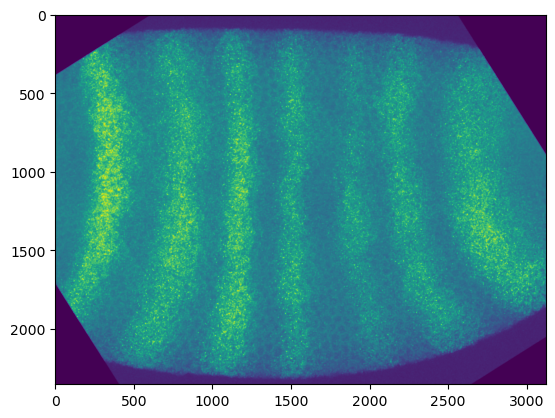

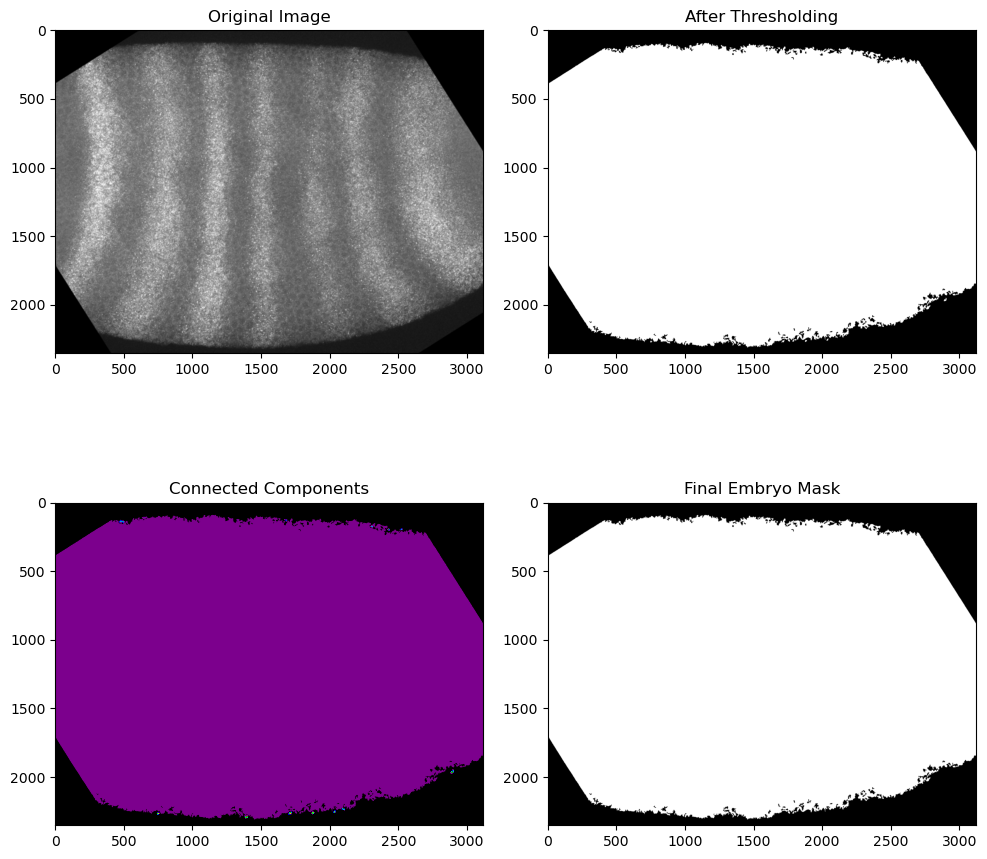

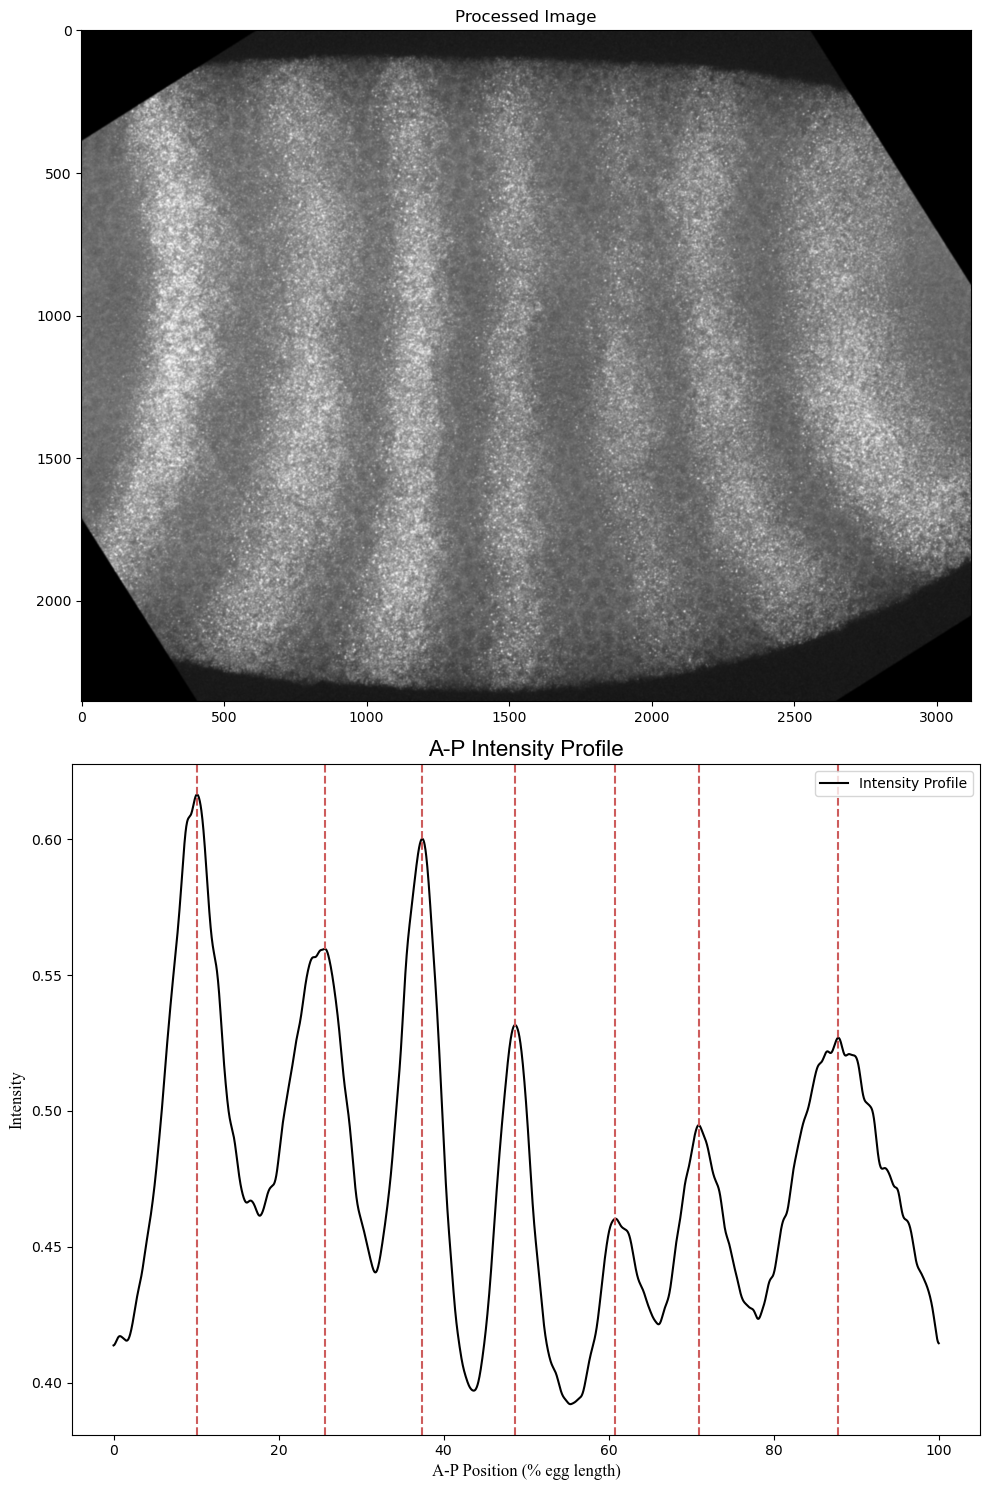

In [48]:

    # Create control embryo profiles
    
    image_path_con = "../control processed images/ctrl eveBAC 2x nc14 timecourse 2crop.tif"
    # Load and preprocess image
    img_con = load_and_preprocess(image_path_con)
    
    # Detect embryo boundary
    embryo_mask_con = detect_embryo_boundary(img_con)
    
    # Generate A-P profile
    ap_positions_con, intensity_profile_con = generate_ap_profile(img_con, embryo_mask_con)
    
    # Detect stripes
    stripes_con = detect_stripes(ap_positions_con, intensity_profile_con)
    print(stripes_con)
    
    # Analyze eve2 stripe
    #eve2_analysis = analyze_eve2_stripe(stripes)
    
    # Create visualization
    fig_con = plot_results(img_con, ap_positions_con, intensity_profile_con, stripes_con)

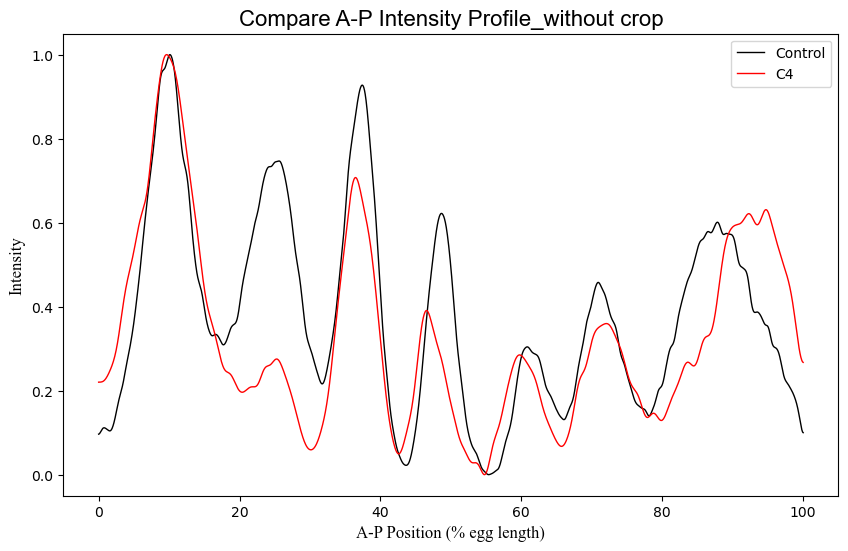

In [34]:
normalized_intensity_profile_con = normalize_intensity(intensity_profile_con)
normalized_intensity_profile_exp = normalize_intensity(intensity_profile_exp)

# Plot the A-P profiles for both embryos
plt.figure(figsize=(10, 6))

# Plot first profile with a specific color
plt.plot(ap_positions_con, normalized_intensity_profile_con, label="Control", color='black', lw=1)

# Plot second profile with a different color
plt.plot(ap_positions_exp, normalized_intensity_profile_exp, label="C4", color='red', lw=1)

plt.xlabel('A-P Position (% egg length)', fontsize=12, family='Times New Roman')
plt.ylabel('Intensity', fontsize=12,family='Times New Roman')
plt.title('Compare A-P Intensity Profile_without crop', fontsize=16, family='Arial')
plt.legend()

peaks =  [ 148  559  713  915 1104 1451]
{'stripe_1': {'center': 9.660574412532638}, 'stripe_2': {'center': 36.48825065274152}, 'stripe_3': {'center': 46.540469973890346}, 'stripe_4': {'center': 59.725848563968675}, 'stripe_5': {'center': 72.0626631853786}, 'stripe_6': {'center': 94.71279373368147}}
[0.00000000e+00 6.52741514e-02 1.30548303e-01 ... 9.98694517e+01
 9.99347258e+01 1.00000000e+02] [0.30605271 0.30605325 0.30605454 ... 0.30872503 0.30863629 0.30859168]


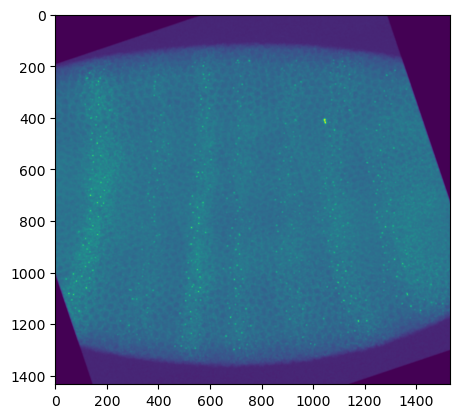

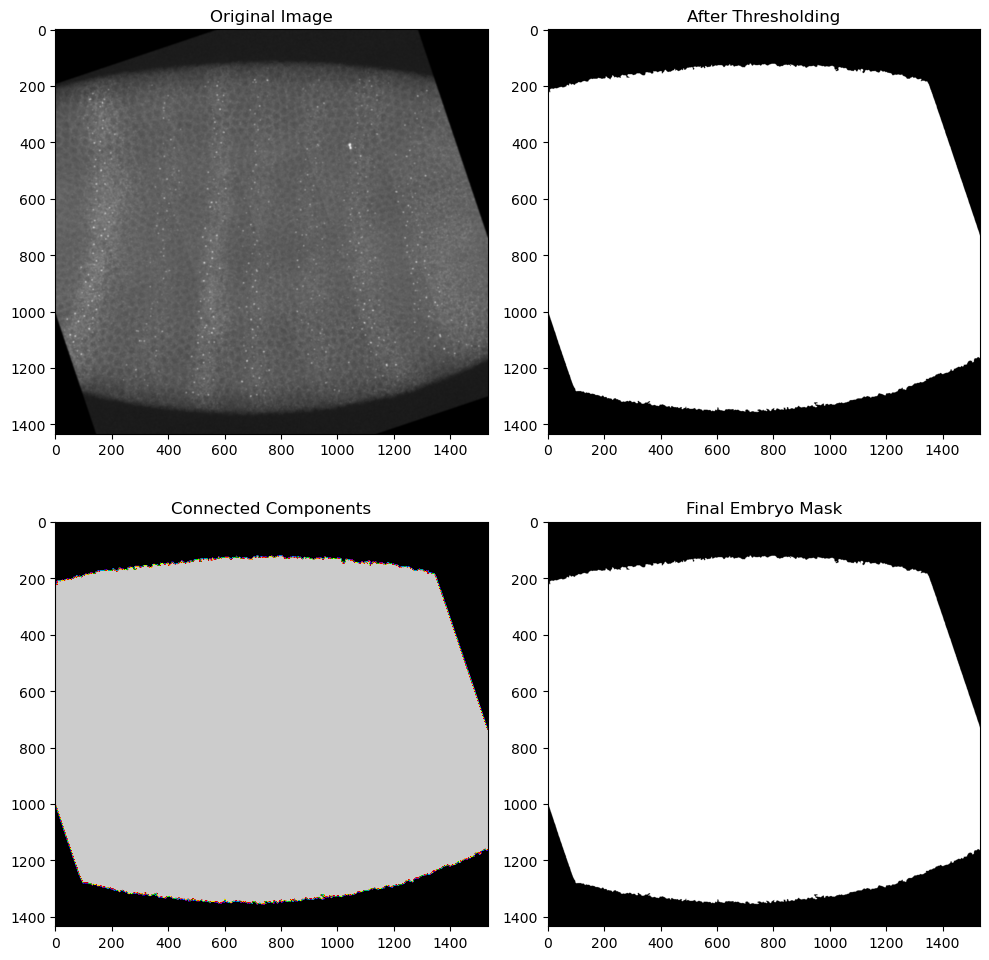

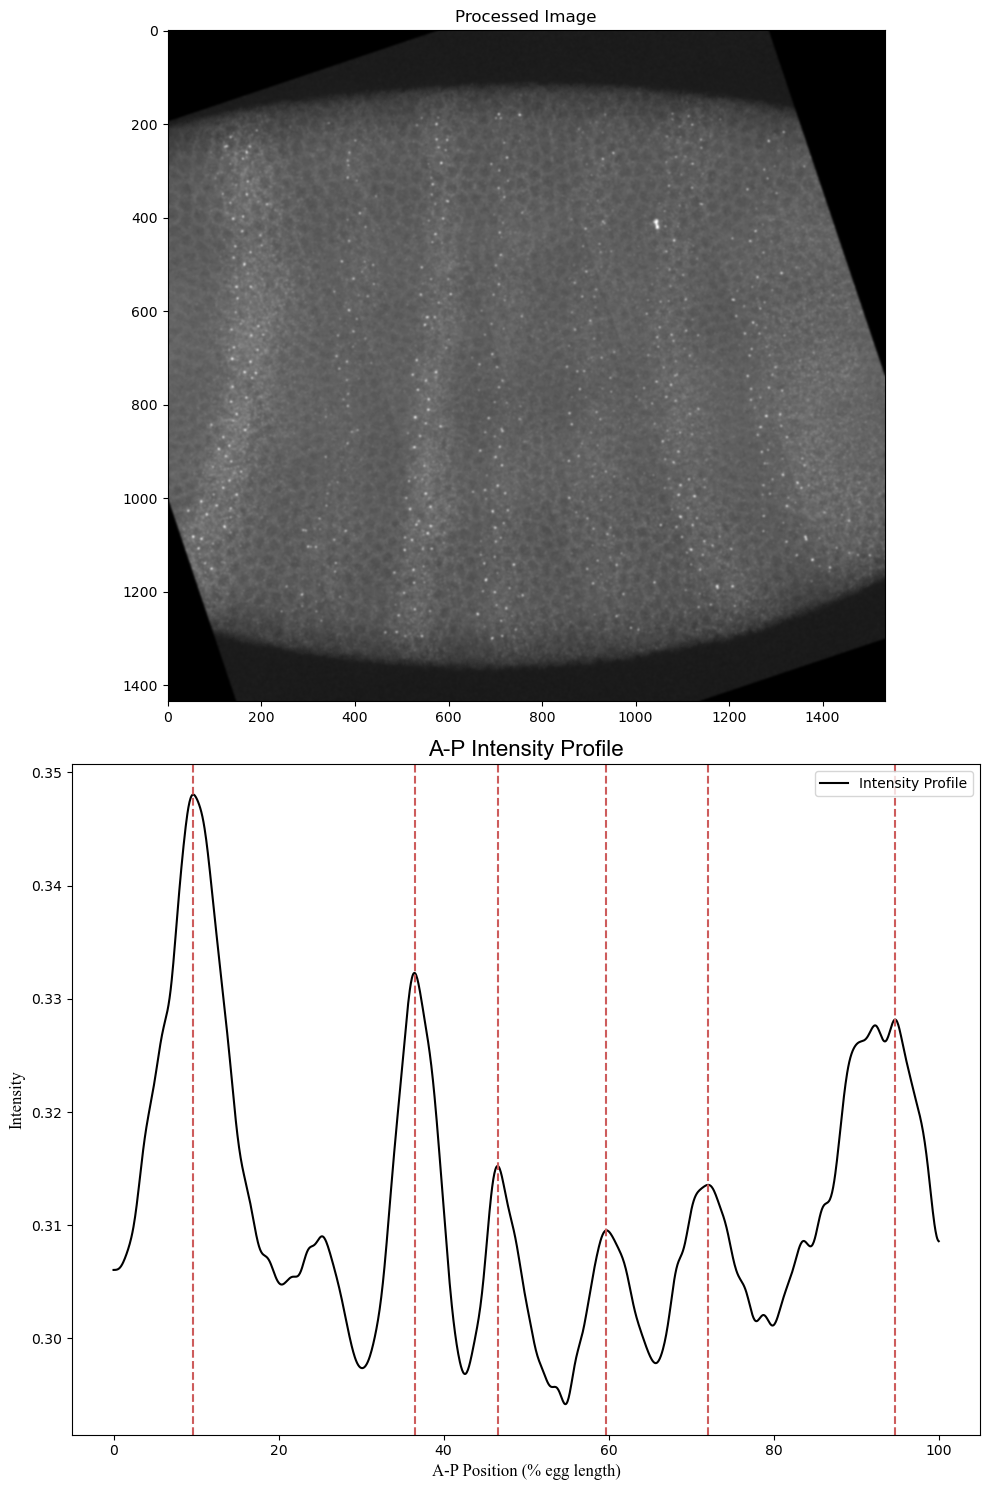

In [94]:

image_path_exp = "./processed images/C4 z=2 8b green.tif"
# Load and preprocess image
img_exp = load_and_preprocess(image_path_exp)

# Detect embryo boundary
embryo_mask_exp = detect_embryo_boundary(img_exp)

# Generate A-P profile
ap_positions_exp, intensity_profile_exp = generate_ap_profile(img_exp, embryo_mask_exp)

# Detect stripes
stripes_exp = detect_stripes(ap_positions_exp, intensity_profile_exp)
print(stripes_exp)

# Create visualization
fig_exp = plot_results(img_exp, ap_positions_exp, intensity_profile_exp, stripes_exp)


peaks =  [ 316  799 1167 1518 1897 2212 2739]
{'stripe_1': {'center': 10.131452388586085}, 'stripe_2': {'center': 25.617184995190765}, 'stripe_3': {'center': 37.41583840974671}, 'stripe_4': {'center': 48.66944533504328}, 'stripe_5': {'center': 60.82077588970824}, 'stripe_6': {'center': 70.9201667201026}, 'stripe_7': {'center': 87.8166078871433}}
[0.00000000e+00 3.20615582e-02 6.41231164e-02 ... 9.99358769e+01
 9.99679384e+01 1.00000000e+02] [0.41370766 0.41374096 0.41380679 ... 0.41473458 0.41457582 0.4144958 ]


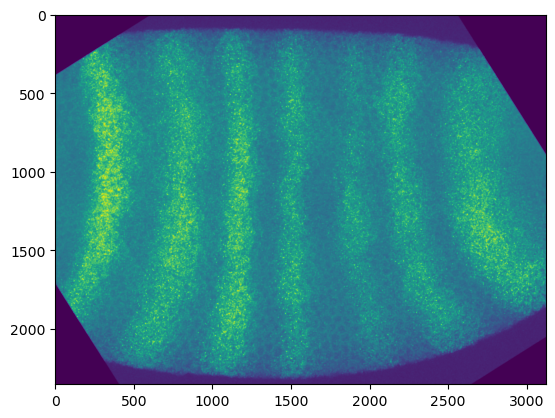

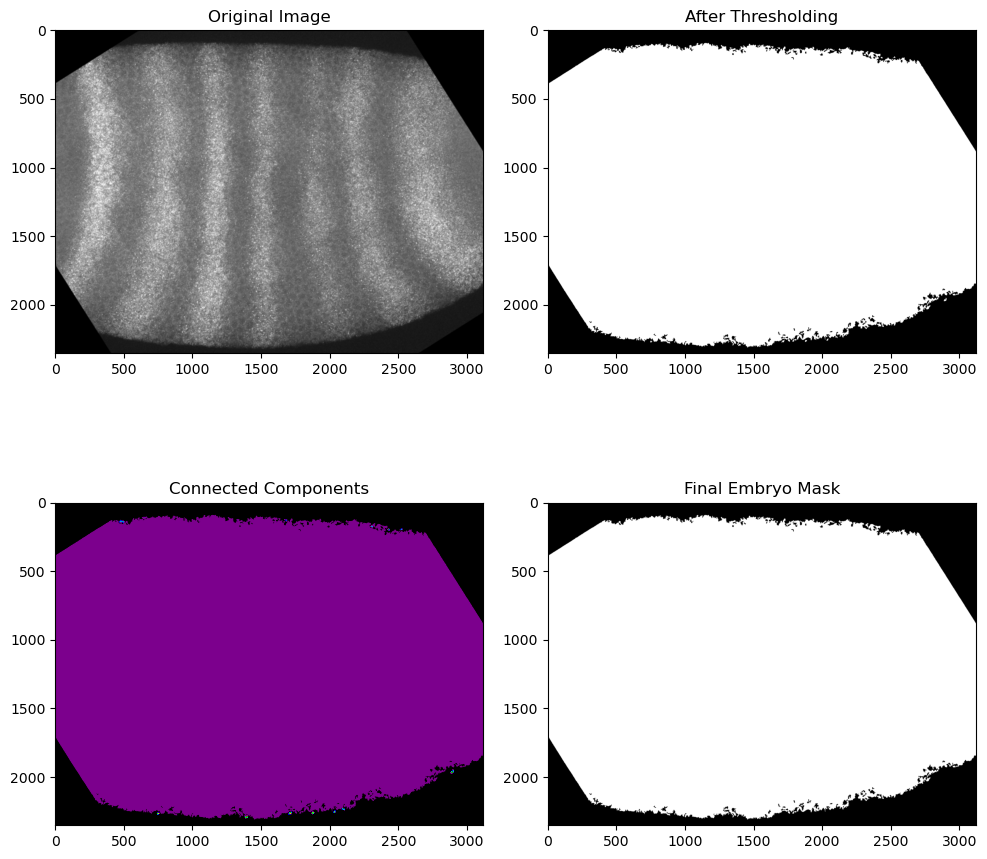

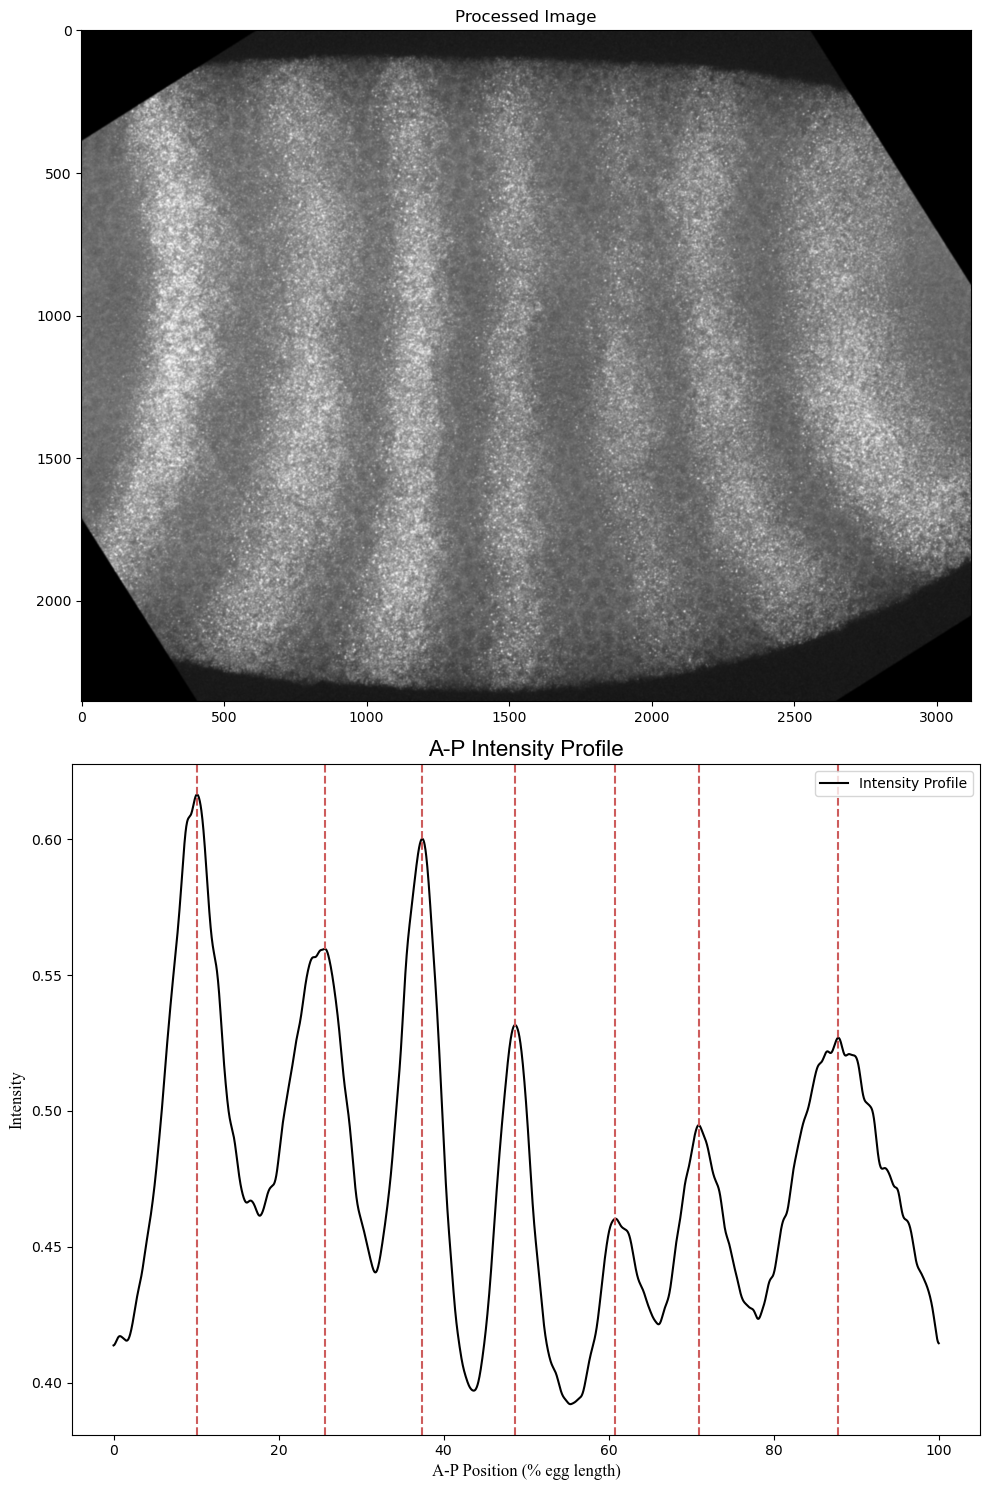

In [50]:
#Control
image_path_con = "../control processed images/ctrl eveBAC 2x nc14 timecourse 2crop.tif"
# Load and preprocess image
img_con = load_and_preprocess(image_path_con)

# Detect embryo boundary
embryo_mask_con = detect_embryo_boundary(img_con)

# Generate A-P profile
ap_positions_con, intensity_profile_con = generate_ap_profile(img_con, embryo_mask_con)

# Detect stripes
stripes_con = detect_stripes(ap_positions_con, intensity_profile_con)
print(stripes_con)

# Create visualization
fig_con = plot_results(img_con, ap_positions_con, intensity_profile_con, stripes_con)

length of ap_profile is: 1533
length of adjusted_ap_profile is: 1533
start_idx: 0
end_idx: 1532
peaks[0] - (peaks[1] - peaks[0]) // 2: -56
len(ap_profile) - 1: 1532
peaks[-1] + (peaks[-1] - peaks[-2]) // 2: 1625
length of ap_profile is: 3120
length of adjusted_ap_profile is: 2927
start_idx: 76
end_idx: 3002
peaks[0] - (peaks[1] - peaks[0]) // 2: 76
len(ap_profile) - 1: 3119
peaks[-1] + (peaks[-1] - peaks[-2]) // 2: 3002


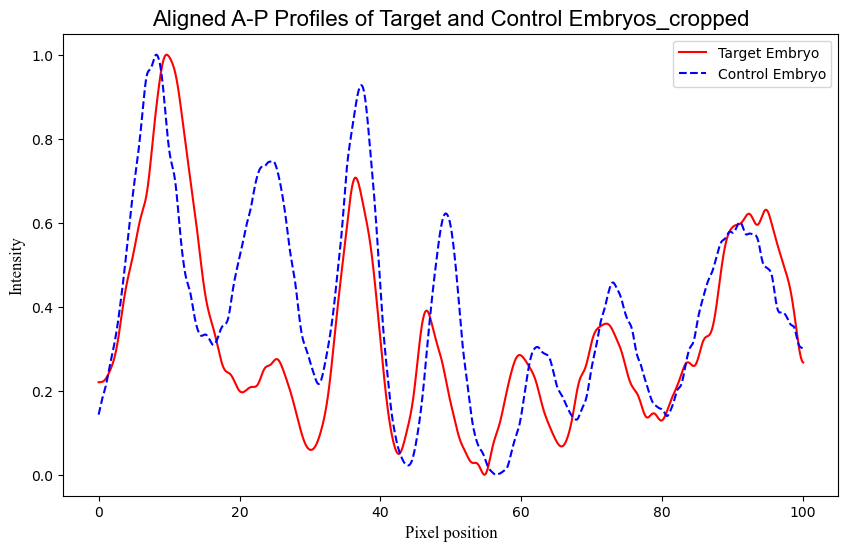

In [52]:
# Compare two embryos from the start of the first stripe to the end of the last stripe

# Detect and crop profiles to stripe boundaries
target_Crop, target_start, target_end = detect_stripe_boundaries_afterCrop(intensity_profile_exp, sigma=5, prominence=0.005)
control_Crop, control_start, control_end = detect_stripe_boundaries_afterCrop(intensity_profile_con, sigma=5, prominence=0.005)

# Normalize profiles
target_normalized = normalize_intensity(target_Crop)
control_normalized = normalize_intensity(control_Crop)

# Align and plot the normalized profiles
align_and_plot_profiles(target_normalized, control_normalized, 
                        (target_start, target_end), (control_start, control_end))
